# Frozen Lake


#### import all requirements

In [4]:
import gym

In [5]:
import torch
import time
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import random

#### register 4x4 environment

In [7]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)


In [8]:

env = gym.make('FrozenLakeNotSlippery-v0')

# Instantiate the Environment.
# env = gym.make('FrozenLake-v0')

# To check all environments present in OpenAI
# print(envs.registry.all())

# visualize 4x4 frozen lake
env.render()


SFFF
FHFH
FFFH
HFFG


In [9]:
# Total number of States and Actions
n_states = env.observation_space.n
n_actions = env.action_space.n
n_rows = int(np.sqrt(n_states))
n_cols = int(np.sqrt(n_states))
print( "States = ", n_states)
print( "Actions = ", n_actions)
print('Rows = ', n_rows)
print('Cols = ', n_cols)

States =  16
Actions =  4
Rows =  4
Cols =  4


In [10]:
# Start with 80% random actions to explore the environment
# exploration decays with each timestep by a factor of 0.999 until it hits 10% exploration rate 

epsilon = 0.8
epsilon_final = 0.1
epsilon_decay = 0.999

In [11]:
gamma = 0.90 # discount factor
learning_rate = 0.9 #how important is the difference between q-val from q-table and what's observed

#### Initialize Q-table

In [12]:

#Q = np.random.rand(15,4)*(1/100)
#Q = np.vstack([Q, np.zeros((1,4))])

Q = np.zeros((n_states,n_actions))
Q.shape

(16, 4)

In [13]:
Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [14]:
##assign index to each state using state-matrix

state_matrix = np.arange(0,16).reshape(4,4)
state_matrix

def rowsandcols(state):
  ''' input: state returned by env
      output: location of state as (row,col) tuple'''
  return int(np.where(state_matrix ==state)[0]), int(np.where(state_matrix ==state)[1])

In [15]:
def choose_random_action(state): 

    ''' input:
      state = state returned by env.
      output = a random action depending on 
      whether the state is an edge/ corner or landlocked tile'''
    k = np.arange(1,n_rows)
   ##corner points    
    if rowsandcols(state)==( 0,0):
      action = random.choice([1,2])
    elif rowsandcols(state) ==(0,n_cols -1):
      action = random.choice([0,1])
    elif rowsandcols(state)==(n_rows -1 , 0):
      action = random.choice([2,3])
    elif rowsandcols(state)==(n_rows -1 , n_cols -1 ):
      action = random.choice([0,3])
    ## no action needed to be chosen for (3,3) -- terminal state 

    ##edge tiles
    elif rowsandcols(state)[0] == 0 and rowsandcols(state)[1] in k:
      action = random.choice([0,1,2])
    elif rowsandcols(state)[0] in k and rowsandcols(state)[1]  == 0:
      action = random.choice([1,2,3])
    elif rowsandcols(state)[0] in k and rowsandcols(state)[1] == n_cols -1:
      action = random.choice([0,1,3])
    elif rowsandcols(state)[0] == n_rows -1 or rowsandcols(state)[1] in k :
      action = random.choice([0,2,3])
  
    else:
      action = env.action_space.sample()
    
    return action

In [40]:
def choose_max_action(state, Q):
    ''' input:
      state = state returned by env.
      Q = current Q-table
      output = argmax of max q-val for a state '''

   ##corner points    
    if state == 0:
      max_val = np.max(Q[state][1:3])
      
    elif state== 3:
      max_val = np.max(Q[state][0:2])

    elif state == 12:
      max_val = np.max(Q[state][2,3])
    ## no action needed to be chosen for (3,3) -- terminal state 

    ##edge tiles
    elif rowsandcols(state)  == (0,1) or rowsandcols(state)  ==  (0,2):
      max_val = np.max(Q[state][0:3])
    elif rowsandcols(state) == (1,0) or rowsandcols(state)  == (2,0):
      max_val = np.max(Q[state][1:])
    elif rowsandcols(state) == (1,3) or rowsandcols(state) == (2,3):
      max_val = np.max(Q[state][[0,1,3]])
    elif rowsandcols(state) == (3,1) or rowsandcols(state) == (3,2) :
      max_val = np.max(Q[state][[0,2,3]])
  
    else:
      max_val = np.max(Q[state])
      
    action = np.where(Q[state]==max_val)[0][0]
    
    return int(action)

In [13]:
#arr = np.arange(0,64).reshape(16,4)
#np.where(Q[13]==np.max(Q[13]))[0][0]

0

In [16]:
num_episodes = 1000
steps_total = [] # store number of steps taken in each episode
rewards_total = [] #store reward obtained for each episode
epsilon_total = [] #store epsilon obtained at the end of each episode

## q learning

In [17]:
for i_episode in range(num_episodes):
    
    # resets the environment
    state = env.reset()
    step = 0

    while True:
        
        step += 1
        
        
        ## generating a random num
        random_for_epsilon = np.random.rand()
        
        ## if random num lesser or equal to epsilon, then select random action
        if random_for_epsilon <= epsilon:     
            action = choose_random_action(state)  ##replace with action = env.action_space.sample() for action without restrictions
        
        ## else update q-vals for given state with infitismly small random nums and select argmax(a) for Q(s,a)
        else: 
            random_values = Q[state] + np.random.rand(1,n_actions)/100
            action =  np.argmax(random_values)
        
        
        ## as epsilon decays with more timesteps, the prob. of selecting a random val < e decays --> more likely to exploit.     
        if epsilon > epsilon_final:
            epsilon *= epsilon_decay
        
        ## env gives reward and next state and whether we've reached terminal state upon taking a at current state.. 
        new_state, reward, done, info = env.step(action)
        ##if you want reward penalized at for each timestep
        ## reward= reward*(0.9**step) 

        # filling the Q Table - 
        Q[state, action] = (1- learning_rate)*Q[state, action] + learning_rate*(reward + gamma * np.max(Q[new_state]))
        
        # Setting new state for next action
        state = new_state
        
        # env.render()
        
        if done:
            steps_total.append(step)
            rewards_total.append(reward)
            epsilon_total.append(epsilon)
            if i_episode % 10 == 0:
                print('Episode: {} Reward: {} Steps Taken: {}'.format(i_episode,reward, step, epsilon))
            break
        



Episode: 0 Reward: 0.0 Steps Taken: 5
Episode: 10 Reward: 0.0 Steps Taken: 7
Episode: 20 Reward: 0.0 Steps Taken: 2
Episode: 30 Reward: 0.0 Steps Taken: 4
Episode: 40 Reward: 0.0 Steps Taken: 5
Episode: 50 Reward: 0.0 Steps Taken: 11
Episode: 60 Reward: 0.0 Steps Taken: 4
Episode: 70 Reward: 0.0 Steps Taken: 10
Episode: 80 Reward: 0.0 Steps Taken: 8
Episode: 90 Reward: 0.0 Steps Taken: 2
Episode: 100 Reward: 0.0 Steps Taken: 4
Episode: 110 Reward: 0.0 Steps Taken: 4
Episode: 120 Reward: 0.0 Steps Taken: 2
Episode: 130 Reward: 0.0 Steps Taken: 3
Episode: 140 Reward: 0.0 Steps Taken: 2
Episode: 150 Reward: 0.0 Steps Taken: 8
Episode: 160 Reward: 0.0 Steps Taken: 2
Episode: 170 Reward: 0.0 Steps Taken: 7
Episode: 180 Reward: 0.0 Steps Taken: 8
Episode: 190 Reward: 0.0 Steps Taken: 6
Episode: 200 Reward: 0.0 Steps Taken: 2
Episode: 210 Reward: 0.0 Steps Taken: 6
Episode: 220 Reward: 0.0 Steps Taken: 3
Episode: 230 Reward: 0.0 Steps Taken: 6
Episode: 240 Reward: 0.0 Steps Taken: 23
Episode:

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [19]:
plt.axhline(y=6, color='green', linestyle='-')
plt.bar(np.arange(0, 1000), steps_total, 
        width = 0.4, color = 'blue')
plt.xlabel('episode index')
plt.ylabel('number of steps taken')
plt.title('4x4: restricted actions')
plt.show()

Text(0, 0.5, '1 if success, 0 if failure')

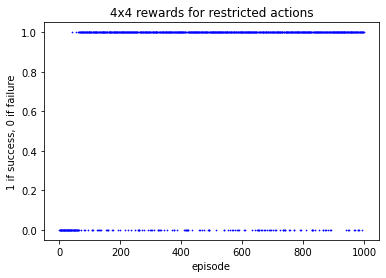

In [53]:

plt.scatter(np.arange(0, 1000), rewards_total, s = 0.5, color = 'blue')
plt.title('4x4 rewards for restricted actions')
plt.xlabel('episode')
plt.ylabel('1 if success, 0 if failure')
plt.show()

In [54]:
##to convert rewards to 1 or 0 when there is a time decay 
##new_rewards_total = [ 1 if i > 0.0 else 0 for i in rewards_total  ]


In [55]:
print(Q)
        
print("Percent of episodes finished successfully: {0}".format(sum(rewards_total)/num_episodes))
print("Percent of episodes finished successfully (last 100 episodes): {0}".format(sum(rewards_total[-100:])/100))

print("Average number of steps: %.2f" % (sum(steps_total)/num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))


[[0.         0.59049    0.4782969  0.        ]
 [0.531441   0.         0.42887448 0.        ]
 [0.47824907 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.6561     0.         0.531441  ]
 [0.         0.         0.         0.        ]
 [0.         0.80983954 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.729      0.59049   ]
 [0.6561     0.81       0.81       0.        ]
 [0.729      0.9        0.         0.72494575]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.9        0.729     ]
 [0.81       0.         1.         0.81      ]
 [0.         0.         0.         0.        ]]
Percent of episodes finished successfully: 0.808
Percent of episodes finished successfully (last 100 episodes): 0.91
Average number of steps: 6.21
Average number of steps (last 100 episodes): 6.24


In [24]:
##convert Q-table to pandas dataframe to export to excel